- This notebook applies the H20 random forest model to the trained data and predicts 'success'.
- The pre-trained model can be loaded in Section 2.1 after running the H20 init.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
plt.style.use('ggplot')

# Loading Training and Test Datasets:

In [8]:
X_train = pd.read_csv('Datasets/X_train.csv')
X_test = pd.read_csv('Datasets/X_test.csv')
y_train = pd.read_csv('Datasets/y_train.csv')
y_test = pd.read_csv('Datasets/y_test.csv')

In [9]:
# Converting object columns and month/year (which are integers) to categorical columns:
list_to_convert = ['month_added', 'year_added', 'beer_style', 'beer_style_group']

for i in list_to_convert:
    X_train[i] = pd.Categorical(X_train[i])

In [10]:
# Concatenating X_train with y_train so that h2o can read the dataframe into an h20 frame below:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train['successful'] = pd.Categorical(Xy_train['successful'])

In [11]:
Xy_train.head(3)

,beer_style,abv,num_ratings,beer_style_group,month_added,year_added,Dominant_Topic,Topic_Perc_Contrib,successful
0,Scottish Ale,5.2,342,Other,5,2018,4.0,0.2573,No
1,Old Ale,5.0,1088,Other,3,2012,6.0,0.1914,No
2,Lager - Winter,7.0,1479,Lager,12,2015,2.0,0.2352,No


In [12]:
Xy_test = pd.concat([X_test, y_test], axis=1)
Xy_test['successful'] = pd.Categorical(Xy_test['successful'])

# The Model:


- I want to retain the beer_style and beer_style group columns as categorical variables, without needing to create numerous dummy variables, to save on memory usage and to keep the dimensionality low when building the model.
- For that reason I cannot use scikit learn's implementation of random forests and instead am using the h2o implementation instead (http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html)

In [4]:
h2o.init(max_mem_size = "960M")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.271-b09, mixed mode, sharing)


C:\Users\rozhouse\Anaconda3\lib\site-packages\h2o\backend\server.py:385: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\Users\rozhouse\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\rozhouse\AppData\Local\Temp\tmpo_zyu7zn
  JVM stdout: C:\Users\rozhouse\AppData\Local\Temp\tmpo_zyu7zn\h2o_rozhouse_started_from_python.out
  JVM stderr: C:\Users\rozhouse\AppData\Local\Temp\tmpo_zyu7zn\h2o_rozhouse_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 29 days
H2O_cluster_name:,H2O_from_python_rozhouse_uo9k6x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,928 Mb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


## Loading the trained model:

In [5]:
# You can load the trained model here rather than re-running everything below, and then skip to section 5 if you would like 
# to re-test the trained model on the test set:
# !! However, you will still need to run H20.init above first !!
beers_model = h2o.load_model('rating_prediction_model\\DRF_model_python_1606406802286_1')

## Creating an H20 dataframe out of the training data:

In [9]:
hf_train = h2o.H2OFrame(Xy_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Defining predictor and target variables:

In [10]:
predictor_cols = X_train.columns.to_list()
target_col = 'successful'

# Gridsearch:


## Setting hyperparameters to search through:

### Split the training set into training and validation sets:

In [9]:
grid_train, grid_valid = hf_train.split_frame(ratios = [.8], seed=42)

In [10]:
grid_search_rf = H2ORandomForestEstimator(nfolds = 10, seed =42)

In [11]:
# Changed these parameters for each different iteration of the gridsearch.
# I had to split up the gridsearches as h2o doesn't allocate enough memory to perform them all at once
rf_params4 = {'ntrees': [500],
                'max_depth': [20]}
              #'mtries': [3, 5, 6]             

In [12]:
rf_grid4 = H2OGridSearch(model=grid_search_rf,
                          grid_id='rf_grid4',
                          hyper_params=rf_params4)

In [15]:
rf_grid4.train(x=predictor_cols, y=target_col,
                training_frame=grid_train,
                validation_frame=grid_valid,
               seed=42)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


## Gridsearch 1 Results:

In [15]:
rfgrid_per_f1 = rf_grid1.get_grid(sort_by='f1', decreasing=True)

In [16]:
rfgrid_per_f1

    max_depth mtries ntrees         model_ids                  f1
0          25      3    100  rf_grid1_model_4  0.7541647906348492
1          20      3    100  rf_grid1_model_3  0.7538322813345356
2          20      2    100  rf_grid1_model_1  0.7517822423849644
3          25      2    100  rf_grid1_model_2  0.7513525210993292
4          25      4    100  rf_grid1_model_6  0.7509736540664377
5          20      4    100  rf_grid1_model_5  0.7508016491067339


## Gridsearch 2 Results:

In [15]:
rfgrid_per_f2 = rf_grid2.get_grid(sort_by='f1', decreasing=True)

In [16]:
rfgrid_per_f2

    max_depth mtries ntrees         model_ids                  f1
0          20      3    150  rf_grid2_model_3  0.7546916890080428
1          25      3    150  rf_grid2_model_4  0.7543546225993748
2          20      4    150  rf_grid2_model_5  0.7543502824858758
3          25      4    150  rf_grid2_model_6  0.7542908762420958
4          20      2    150  rf_grid2_model_1   0.751358695652174
5          25      2    150  rf_grid2_model_2  0.7512965050732807


- mtries = 3 has generated the highest f1 score in both the above grisearches, this is equal to the default mtries setting which is the square root of the number of predictors (8).

## Gridsearch 3 Results:

In [15]:
rfgrid_per_f3 = rf_grid3.get_grid(sort_by='f1', decreasing=True)

In [16]:
rfgrid_per_f3

    max_depth ntrees         model_ids                  f1
0          25    200  rf_grid3_model_4  0.7596367305751766
1          20    200  rf_grid3_model_3  0.7594425368612401
2          20     50  rf_grid3_model_1  0.7545008183306056
3          25     50  rf_grid3_model_2  0.7542129058775175


## Gridsearch 4 Results:

In [17]:
rfgrid_per_f4 = rf_grid4.get_grid(sort_by='f1', decreasing=True)

In [18]:
rfgrid_per_f4

    max_depth ntrees         model_ids                  f1
0          20    500  rf_grid4_model_1  0.7567127746135068


In [22]:
best_rf1 = rfgrid_per_f3.models[0]

## Conclusion:

- From the gridsearches performed above, the hyperparameter selection does not have an outsized impact on the overall f1 score of the model.

- I will select the highest f1 score found in these crossvalidated gridsearches, using the following parameters:
        - Number of trees = 150
        - Number of predictors selected at random (mtries) for each node: default (sqrt of n(predictors) = 2.8 ~ 3).
        - Max Depth = 25

# Building the Model based on best gridsearch parameters:

## Splitting the training set for cross-validation according to specified ratio:

In [11]:
train, valid = hf_train.split_frame(ratios=[.8], seed=42)

## Defining the Model parameters:

In [12]:
beers_model = H2ORandomForestEstimator(ntrees=150, 
                                       max_depth=25, 
                                       nfolds=10,
                                      seed = 42)

## Training the Model:

In [13]:
beers_model.train(predictor_cols, target_col, 
                  training_frame = train,
                 validation_frame = valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


## Saving the Model:

In [19]:
# h2o.save_model(model=beers_model, path="rating_prediction_model", force=True)

## Looking at model performance on the training set:


In [189]:
perf = beers_model.model_performance()

In [190]:
perf.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44051323344011495: 


,,No,Yes,Error,Rate
0,No,7988.0,538.0,0.0631,(538.0/8526.0)
1,Yes,620.0,1741.0,0.2626,(620.0/2361.0)
2,Total,8608.0,2279.0,0.1064,(1158.0/10887.0)


In [191]:
perf.F1()

[[0.44051323344011495, 0.7504310344827586]]

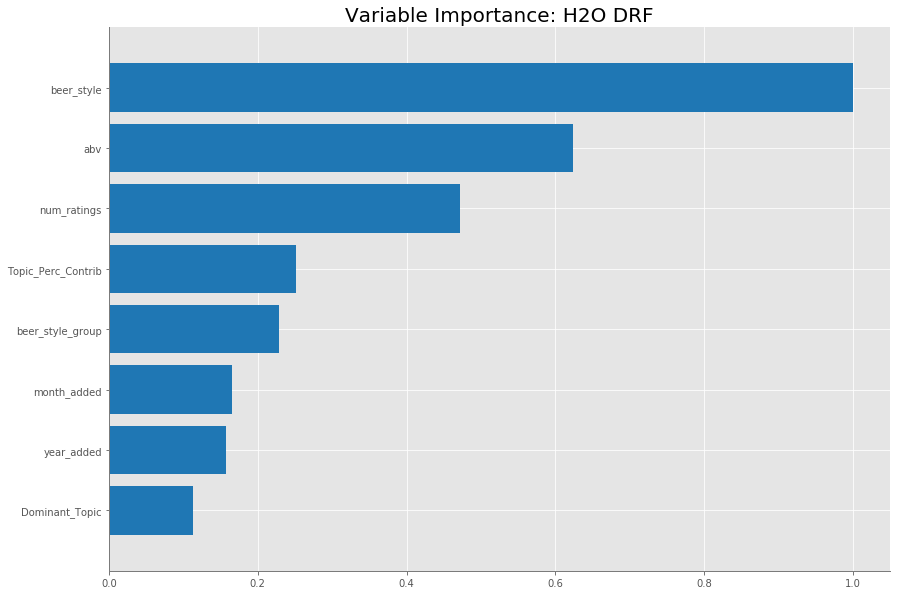

In [192]:
beers_model.varimp_plot()

plt.show()

In [193]:
beers_model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1605539427202_1852


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,150.0,150.0,2497788.0,19.0,25.0,22.44,805.0,1199.0,994.0733




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07785595766708787
RMSE: 0.279026804567389
LogLoss: 0.28613674351650237
Mean Per-Class Error: 0.13647595917830835
AUC: 0.9376563036670948
AUCPR: 0.8247358856395579
Gini: 0.8753126073341897

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44051323344011495: 


,,No,Yes,Error,Rate
0,No,7988.0,538.0,0.0631,(538.0/8526.0)
1,Yes,620.0,1741.0,0.2626,(620.0/2361.0)
2,Total,8608.0,2279.0,0.1064,(1158.0/10887.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.440513,0.750431,187.0
1,max f2,0.197981,0.813653,283.0
2,max f0point5,0.551327,0.787397,150.0
3,max accuracy,0.499860,0.896115,166.0
4,max precision,0.997043,0.978723,1.0
5,max recall,0.000004,1.000000,399.0
6,max specificity,0.999916,0.999883,0.0
7,max absolute_mcc,0.450606,0.683950,183.0
8,max min_per_class_accuracy,0.267012,0.861499,253.0
9,max mean_per_class_accuracy,0.254181,0.863524,259.0



Gains/Lift Table: Avg response rate: 21.69 %, avg score: 21.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010196,0.978723,4.486555,4.486555,0.972973,0.989829,0.972973,0.989829,0.045743,0.045743,348.655517,348.655517,0.045391
1,2,0.020391,0.950000,4.445013,4.465784,0.963964,0.963361,0.968468,0.976595,0.045320,0.091063,344.501299,346.578408,0.090242
2,3,0.030036,0.926053,4.479434,4.470167,0.971429,0.937945,0.969419,0.964184,0.043202,0.134265,347.943365,347.016697,0.133092
3,4,0.040231,0.901961,4.278844,4.421681,0.927928,0.913654,0.958904,0.951379,0.043626,0.177891,327.884428,342.168108,0.175780
4,5,0.050060,0.875266,4.266420,4.391199,0.925234,0.888798,0.952294,0.939092,0.041931,0.219822,326.642045,339.119872,0.216773
5,6,0.100119,0.740000,3.993537,4.192368,0.866055,0.808965,0.909174,0.874028,0.199915,0.419737,299.353718,319.236795,0.408126
6,7,0.149995,0.593228,3.413803,3.933482,0.740331,0.662968,0.853031,0.803847,0.170267,0.590004,241.380303,293.348200,0.561855
7,8,0.200055,0.463927,2.555187,3.588592,0.554128,0.527584,0.778237,0.734718,0.127912,0.717916,155.518693,258.859182,0.661266
8,9,0.299991,0.255501,1.508806,2.895754,0.327206,0.350637,0.627985,0.606769,0.150784,0.868700,50.880578,189.575434,0.726194
9,10,0.400478,0.132075,0.691256,2.342607,0.149909,0.188179,0.508028,0.501738,0.069462,0.938162,-30.874424,134.260722,0.686578




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.08195671348047093
RMSE: 0.28628082974672076
LogLoss: 0.28221068427099744
Mean Per-Class Error: 0.14144889103182257
AUC: 0.9286298617807779
AUCPR: 0.8238654454876048
Gini: 0.8572597235615558

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32354207726319634: 


,,No,Yes,Error,Rate
0,No,1864.0,210.0,0.1013,(210.0/2074.0)
1,Yes,119.0,481.0,0.1983,(119.0/600.0)
2,Total,1983.0,691.0,0.123,(329.0/2674.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.323542,0.745159,235.0
1,max f2,0.202963,0.803274,283.0
2,max f0point5,0.582713,0.783713,145.0
3,max accuracy,0.495619,0.890052,174.0
4,max precision,0.999902,1.000000,0.0
5,max recall,0.000006,1.000000,399.0
6,max specificity,0.999902,1.000000,0.0
7,max absolute_mcc,0.443533,0.672351,191.0
8,max min_per_class_accuracy,0.256188,0.856667,262.0
9,max mean_per_class_accuracy,0.257685,0.858551,261.0



Gains/Lift Table: Avg response rate: 22.44 %, avg score: 21.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010097,0.969588,4.456667,4.456667,1.000000,0.984514,1.000000,0.984514,0.045000,0.045000,345.666667,345.666667,0.045000
1,2,0.020942,0.946667,4.302989,4.377083,0.965517,0.956048,0.982143,0.969772,0.046667,0.091667,330.298851,337.708333,0.091185
2,3,0.030292,0.929989,4.100133,4.291605,0.920000,0.937173,0.962963,0.959711,0.038333,0.130000,310.013333,329.160494,0.128554
3,4,0.040015,0.906756,4.285256,4.290062,0.961538,0.919952,0.962617,0.950050,0.041667,0.171667,328.525641,329.006231,0.169738
4,5,0.050486,0.893333,4.297500,4.291605,0.964286,0.900824,0.962963,0.939840,0.045000,0.216667,329.750000,329.160494,0.214256
5,6,0.100224,0.762968,3.887018,4.090821,0.872180,0.823283,0.917910,0.881996,0.193333,0.410000,288.701754,309.082090,0.399392
6,7,0.149963,0.609600,3.317368,3.834289,0.744361,0.683852,0.860349,0.816277,0.165000,0.575000,231.736842,283.428928,0.547999
7,8,0.200075,0.458667,2.427886,3.482031,0.544776,0.529751,0.781308,0.744512,0.121667,0.696667,142.788557,248.203115,0.640254
8,9,0.299925,0.256238,1.585705,2.850711,0.355805,0.346506,0.639651,0.612009,0.158333,0.855000,58.570537,185.071072,0.715656
9,10,0.400524,0.133333,0.646134,2.296993,0.144981,0.187519,0.515406,0.505391,0.065000,0.920000,-35.386617,129.699346,0.669759




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.07774449807735162
RMSE: 0.27882700385248127
LogLoss: 0.26753777852579314
Mean Per-Class Error: 0.13433541054330855
AUC: 0.938193092598736
AUCPR: 0.8272868504744819
Gini: 0.8763861851974719

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3708191046260652: 


,,No,Yes,Error,Rate
0,No,7804.0,722.0,0.0847,(722.0/8526.0)
1,Yes,499.0,1862.0,0.2114,(499.0/2361.0)
2,Total,8303.0,2584.0,0.1122,(1221.0/10887.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.370819,0.753084,218.0
1,max f2,0.224183,0.812606,277.0
2,max f0point5,0.566040,0.780763,146.0
3,max accuracy,0.516950,0.895196,164.0
4,max precision,0.999825,1.000000,0.0
5,max recall,0.000013,1.000000,399.0
6,max specificity,0.999825,1.000000,0.0
7,max absolute_mcc,0.375865,0.681995,216.0
8,max min_per_class_accuracy,0.266030,0.862770,260.0
9,max mean_per_class_accuracy,0.251378,0.865665,265.0



Gains/Lift Table: Avg response rate: 21.69 %, avg score: 21.68 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.964470,4.526573,4.526573,0.981651,0.978799,0.981651,0.978799,0.045320,0.045320,352.657286,352.657286,0.045085
1,2,0.020024,0.939369,4.357355,4.441964,0.944954,0.949893,0.963303,0.964346,0.043626,0.088945,335.735519,344.196403,0.088007
2,3,0.030036,0.913378,4.484268,4.456065,0.972477,0.927240,0.966361,0.951978,0.044896,0.133842,348.426844,345.606550,0.132551
3,4,0.040048,0.890093,4.399660,4.441964,0.954128,0.900954,0.963303,0.939222,0.044049,0.177891,339.965961,344.196403,0.176014
4,5,0.050060,0.868303,4.357355,4.425042,0.944954,0.879403,0.959633,0.927258,0.043626,0.221516,335.735519,342.504226,0.218936
5,6,0.100028,0.729863,4.009355,4.217389,0.869485,0.799997,0.914601,0.863686,0.200339,0.421855,300.935468,321.738933,0.410947
6,7,0.149995,0.590000,3.305810,3.913716,0.716912,0.658688,0.848745,0.795395,0.165184,0.587039,230.581041,291.371576,0.558069
7,8,0.200331,0.460000,2.566442,3.575199,0.556569,0.523390,0.775332,0.727051,0.129183,0.716222,156.644237,257.519865,0.658751
8,9,0.299991,0.255089,1.559727,2.905637,0.338249,0.348607,0.630129,0.601328,0.155443,0.871665,55.972690,190.563746,0.729980
9,10,0.401488,0.133333,0.667682,2.339877,0.144796,0.187253,0.507435,0.496649,0.067768,0.939432,-33.231758,133.987669,0.686911




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.89541376,0.007124638,0.90400743,0.8947368,0.8872114,0.890511,0.89349115,0.9094942,0.8937729,0.9000908,0.89311594,0.8877057
1,auc,0.9382076,0.0065452266,0.9251042,0.93908536,0.93815213,0.9443347,0.93620914,0.94219935,0.93731606,0.94933116,0.932656,0.93768847
2,aucpr,0.827304,0.015382379,0.8227678,0.82987714,0.82995474,0.81222415,0.81115717,0.8518359,0.82982516,0.852363,0.80819917,0.8248357
3,err,0.104586266,0.007124638,0.09599254,0.10526316,0.11278863,0.10948905,0.10650887,0.090505764,0.10622711,0.09990917,0.106884055,0.11229429
4,err_count,113.8,7.899367,103.0,118.0,127.0,120.0,108.0,102.0,116.0,110.0,118.0,116.0
5,f0point5,0.7567208,0.02370965,0.79390115,0.7517348,0.7377676,0.72789633,0.7509328,0.7962529,0.7400157,0.7759939,0.7467811,0.74593127
6,f1,0.7614321,0.019297227,0.745679,0.7677165,0.75243664,0.76095617,0.74883723,0.8,0.7651822,0.7868217,0.7467811,0.7399103
7,f2,0.7673614,0.0336006,0.7029795,0.7843926,0.76770085,0.79716194,0.7467533,0.8037825,0.7921207,0.797956,0.7467811,0.7339858
8,lift_top_group,4.4871697,0.16105634,4.3742356,4.57551,4.540323,4.294671,4.267677,4.4545455,4.686695,4.3690476,4.7381973,4.5707965
9,logloss,0.26748672,0.023927098,0.31752273,0.25423482,0.25407413,0.24553391,0.25972122,0.30420122,0.252215,0.27020153,0.2600043,0.25715828



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-11-17 12:54:01,21.526 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-11-17 12:54:01,21.544 sec,1.0,0.420277,6.047663,0.739677,0.494422,2.818249,0.178230,0.418437,5.973680,0.740974,0.494741,2.725300,0.175393
2,,2020-11-17 12:54:01,21.565 sec,2.0,0.402183,5.194467,0.764769,0.516584,2.885683,0.176534,0.351860,2.790292,0.825946,0.631308,3.469344,0.179132
3,,2020-11-17 12:54:01,21.588 sec,3.0,0.386620,4.459128,0.783929,0.541320,2.990220,0.177501,0.326572,1.823292,0.864446,0.692713,3.698085,0.132386
4,,2020-11-17 12:54:02,21.613 sec,4.0,0.376215,3.956454,0.795485,0.557035,3.076322,0.169912,0.318441,1.408518,0.875106,0.724479,3.955918,0.140987
5,,2020-11-17 12:54:02,21.639 sec,5.0,0.365244,3.440464,0.813653,0.579569,3.151990,0.166276,0.311307,1.174568,0.885542,0.746168,4.048867,0.143979
6,,2020-11-17 12:54:02,21.667 sec,6.0,0.354742,2.969864,0.827477,0.602005,3.265648,0.160192,0.305637,0.988928,0.896852,0.758960,4.036836,0.125280
7,,2020-11-17 12:54:02,21.757 sec,7.0,0.345532,2.600225,0.838263,0.625367,3.389179,0.158232,0.300788,0.746495,0.906594,0.776895,4.170459,0.132012
8,,2020-11-17 12:54:02,21.791 sec,8.0,0.336597,2.247856,0.851404,0.650515,3.516931,0.151672,0.297311,0.648018,0.911297,0.789152,4.267021,0.118923
9,,2020-11-17 12:54:02,21.825 sec,9.0,0.330453,2.025349,0.859214,0.667875,3.603774,0.144151,0.295043,0.621279,0.913269,0.798115,4.299373,0.122663



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,beer_style,62167.070312,1.000000,0.332130
1,abv,38780.707031,0.623814,0.207187
2,num_ratings,29370.861328,0.472450,0.156915
3,Topic_Perc_Contrib,15597.786133,0.250901,0.083332
4,beer_style_group,14182.904297,0.228142,0.075773
5,month_added,10303.702148,0.165742,0.055048
6,year_added,9768.126953,0.157127,0.052187
7,Dominant_Topic,7006.034668,0.112697,0.037430


# Evaluating the Model on the Test Set:

## Creating a h2o frame out of the test set:

In [13]:
hf_test = h2o.H2OFrame(Xy_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Making predictions on the test set using the trained model:

In [14]:
pred = beers_model.predict(hf_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [15]:
# Converting predictions to a pandas dataframe:
pred_as_df = h2o.as_list(pred)

In [16]:
# Combining predictions with y_test df:
pred_df = pd.concat([pred_as_df, y_test], axis=1)

In [17]:
# Adding a column to count successful and unsuccessful predictions:
pred_df['correct'] = np.where(pred_df['predict']==pred_df['successful'], 1, 0)
pred_df['incorrect'] = np.where(pred_df['predict']!=pred_df['successful'], 1, 0)

In [18]:
pred_df.head(3)

,predict,No,Yes,successful,correct,incorrect
0,No,1.00,0.00,No,1,0
1,Yes,0.54,0.46,Yes,1,0
2,No,1.00,0.00,No,1,0


## Calculating metrics manually:

In [19]:
tp = pred_df[(pred_df['successful']=='Yes')&(pred_df['predict']=='Yes')].correct.sum()
tn = pred_df[(pred_df['successful']=='No')&(pred_df['predict']=='No')].correct.sum()
fp = pred_df[(pred_df['successful']=='No')&(pred_df['predict']=='Yes')].incorrect.sum()
fn = pred_df[(pred_df['successful']=='Yes')&(pred_df['predict']=='No')].incorrect.sum()

In [20]:
Accuracy = (tp+tn)/(tp+fn+fp+tn)
Sensitivity = tp / (tp + fn)
Specificity = tn / (tn + fp)
F1_Score = (2*tp) / ((2*tp)+fp+fn)

In [21]:
print("Accuracy of the model: %.3f" %Accuracy)
print("Sensitivity of the model: %.3f" %Sensitivity)
print("Specificity of the model: %.3f" %Specificity)
print("F1_Score of the model: %.3f" %F1_Score)

Accuracy of the model: 0.881
Sensitivity of the model: 0.817
Specificity of the model: 0.900
F1_Score of the model: 0.756


In [22]:
pred_df.to_csv('Datasets/test_set_predictions.csv')

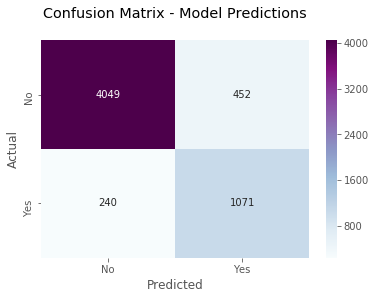

In [23]:
confusion_matrix = pd.crosstab(pred_df['successful'], 
                               pred_df['predict'], 
                               rownames=['Actual'], colnames=['Predicted'])


ax = sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap = 'BuPu')

# Using the below to correct for errors in correlogram, making the squares uneven
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title("Confusion Matrix - Model Predictions\n")
plt.show()

# Could Altering the threshold make a better model?

- h2o tests various thresholds on the test set (and the optimal model chose 0.396) , I will have a look at what an ideal threshold may have been given the predictions on the test set and will plot the changes as the threshold moves up/down:

In [204]:
thresholds = list(np.linspace(0.1,1,50))

In [205]:
pred_df2 = pred_df.copy()

## Looping through a list of possible threshold levels (to define successful above), using the test predictions:

In [206]:
accuracy = []
f1_score = []
for t in thresholds:
    pred_df2['predict'] = np.where(pred_df['Yes']>=t, 'Yes', 'No')
    tp = np.where((pred_df2['successful']=='Yes')&(pred_df2['predict']=='Yes') , 1, 0).sum()
    tn = np.where((pred_df2['successful']=='No')&(pred_df2['predict']=='No') , 1, 0).sum()
    fp = np.where((pred_df2['successful']=='No')&(pred_df2['predict']=='Yes') , 1, 0).sum() 
    fn = np.where((pred_df2['successful']=='Yes')&(pred_df2['predict']=='No') , 1, 0).sum()
    a = (tp+tn)/(tp+fn+fp+tn)
    accuracy.append(a)
    f = (2*tp) / ((2*tp)+fp+fn)
    f1_score.append(f)

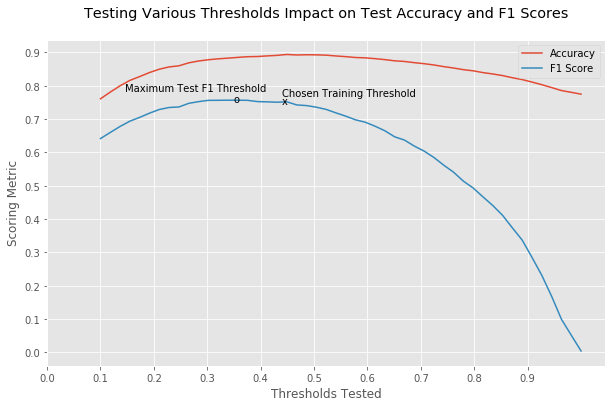

In [216]:
plt.figure(figsize=(10,6))

plt.plot(thresholds, accuracy)
plt.plot(thresholds, f1_score)

plt.xlabel('Thresholds Tested')
plt.ylabel('Scoring Metric')
plt.title('Testing Various Thresholds Impact on Test Accuracy and F1 Scores\n')
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))

plt.text(0.44,0.745,'x')
plt.text(0.44,0.77,'Chosen Training Threshold')
plt.text(0.35,0.75,'o')
plt.text(0.41,0.785,'Maximum Test F1 Threshold',horizontalalignment='right')

plt.legend(['Accuracy', 'F1 Score'], fontsize = 10)
plt.show()

## Getting the threshold where f1 score was maximised on the test predictions:

In [214]:
f1_score.index(max(f1_score))

14

In [215]:
thresholds[14]

0.3571428571428572

- As you can see above, there is very little difference in f1 score between the best possible threshold chosen based on seeing the test set, vs. the one chosen by the h2o model using the training data set.
- The one chosen actually results in a higher accuracy score also.